##### Visualize Mixing Depth and PAR over full hindcast <br>
G Oldford
Apr 2023

Purpose: generate hovmollers and climatological profile along N-S (maybe thalweg later)
         and trends of mixing layer depth and photosynthetically available radiation 
         
Data in: mixing layer depth (monthly, either NC or ASC, clipped to ECOSPACE - opting for ASCs here)

Code based on work by Tereza Jarnikova to generate the figs and analysis for temp, salin

Notes: 2023-04-03 - missing mixing data for 2018

In [295]:
import numpy as np
import xarray as xr
import pandas as pd

## load ASC files used in ECOSPACE
## Load data as-is into xarray dataset and then row-wise avg as xr

path_data = "../data/output/RUN203/ECOSPACE/"
mxng_p = "NEMO_prepped_as_ASC/{var}/"
tmp_p = "NEMO_prepped_as_ASC/{var}/"
li_p = "ECOSPACE_in_PAR3/{var}/"

# template file names w/ var names
v_f = {"MixedLyrZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc", 
       "MixingTurboZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "TempVertMean10m":path_data + tmp_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",  
       "PAR-VarZ-VarK":path_data + li_p + "{var}_{year}_{month}.asc"}

yr_strt = 1979
yr_end = 2017
months_d = {"01": 1, "02": 2, "03": 3,"04": 4,"05": 5,"06": 6,"07": 7,"08": 8,"09": 9,"10": 10,"11": 11,"12": 12}
months = list(range(1,12))

rows = 151
cols = 93
months = 12

skiprows = 6 # header

time = pd.date_range(start='{yr_strt}-01-01'.format(yr_strt=yr_strt), 
                              end='{yr_end}-12-01'.format(yr_end=yr_end), 
                              freq='MS')+ pd.DateOffset(days=14)

# empty ds for all 
ds = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'Example dataset of monthly ASC files',
    }
)

# create empty variable with correct shape
for v in v_f:
    ds[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows, cols)),
        dims=('time', 'row', 'col'),
        attrs={'description': f'{v} data'}
    )

# load the data
for v in v_f:
    attribute = v_f[v]
    for y in range(yr_strt, yr_end+1):
        for m in sorted(months_d.keys()):
            f_n = v_f[v].format(var=v,year=y,month=m)
            with open(f_n) as f:
                data = np.loadtxt(f,skiprows=skiprows)
                
                data[data==-9999.0]=['nan']
                data[data==0.0]=['nan']
                
                ds[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    data,
                    dims=('row', 'col'),
                    attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )
                
# second dataset to store the row-wise averages 
ds2 = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
    },
    attrs={
        'description': 'Example dataset of monthly ASC files',
    }
)

# empty variable with correct shape for ds2
for v in v_f:
    ds2[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows)),
        dims=('time','row'),
        attrs={'description': f'{v} avg row-wise'}
    )
    
# Calculates row-wise averages for each attribute and each month
for v in v_f:
    for y in range(yr_strt, yr_end+1):   
        for m in sorted(months_d.keys()):
            # Select the data for this attribute and month
            data = ds[v].sel(time=f'{y}-{m}'.format(y=y,m=m))

            # Calculate the row-wise average and print it
            row_avg = data.mean(dim='col')
            
            ds2[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    row_avg[0],
                    dims=('row'),
                    attrs={'description': f'{v} avg row-wise data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )
            

In [296]:
ds2

<xarray.Dataset>
Dimensions:          (time: 468, row: 151)
Coordinates:
  * time             (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2017-12-15
  * row              (row) int32 1 2 3 4 5 6 7 8 ... 145 146 147 148 149 150 151
Data variables:
    MixedLyrZ        (time, row) float64 12.81 12.37 12.82 ... 16.17 15.98 16.57
    MixingTurboZ     (time, row) float64 13.35 13.2 13.44 ... 30.75 29.39 29.73
    TempVertMean10m  (time, row) float64 5.42 5.591 5.474 ... 7.623 7.208 7.224
    PAR-VarZ-VarK    (time, row) float64 9.1 9.326 9.258 ... 7.243 7.078 6.489
Attributes:
    description:  Example dataset of monthly ASC files

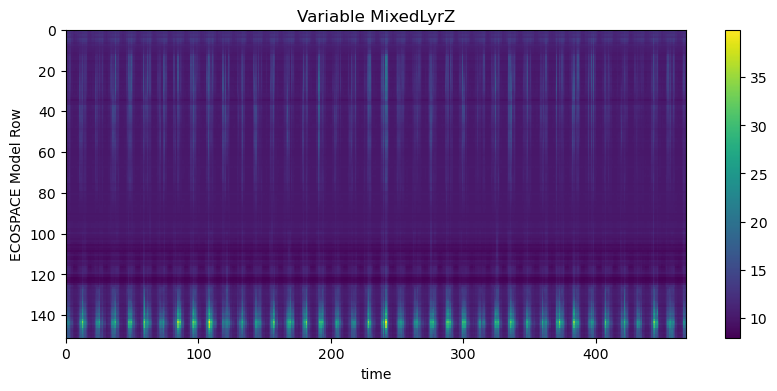

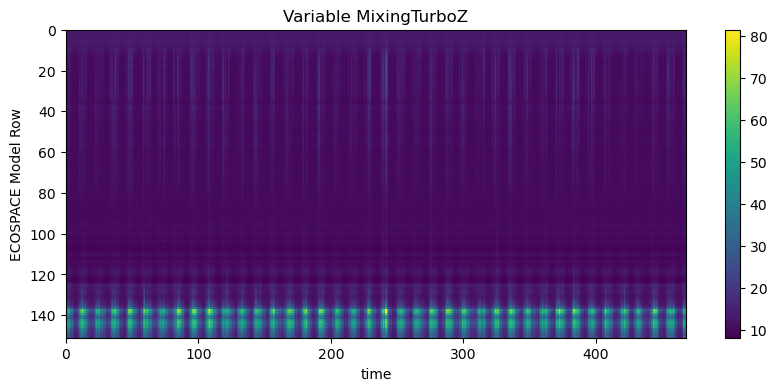

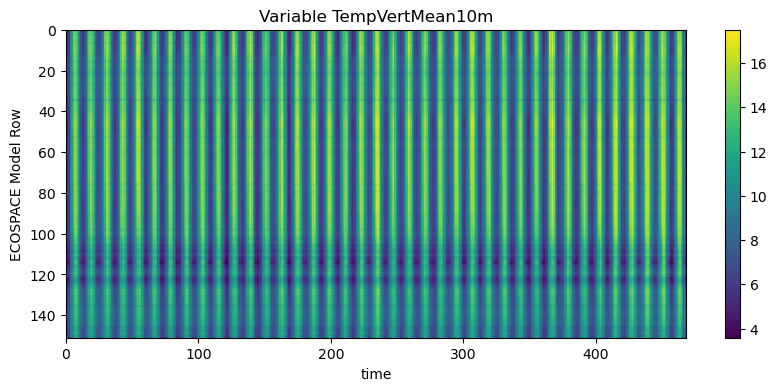

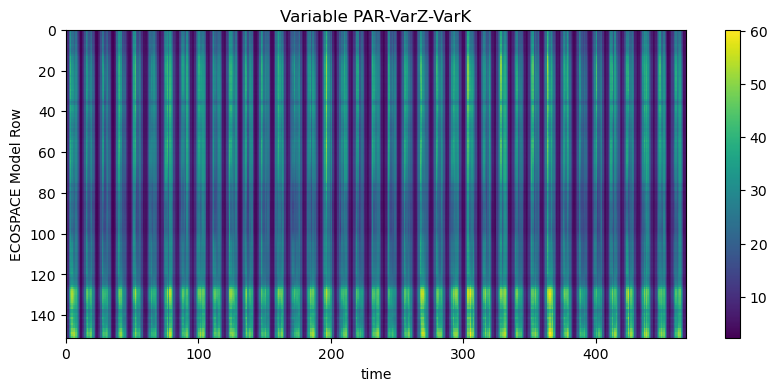

In [297]:
import cartopy as cp
import matplotlib.pyplot as plt
import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm

# check we have data, plots working
for v in v_f:
    v1 = ds2[v]
    fig, axs = plt.subplots(figsize = (10,4))
    w = plt.pcolormesh(xr.DataArray.transpose(v1))
    axs.set_title('Variable {v}'.format(v=v))
    plt.colorbar(w, ax = axs)
    axs.invert_yaxis()
    axs.set_xlabel('time')
    axs.set_ylabel('ECOSPACE Model Row')


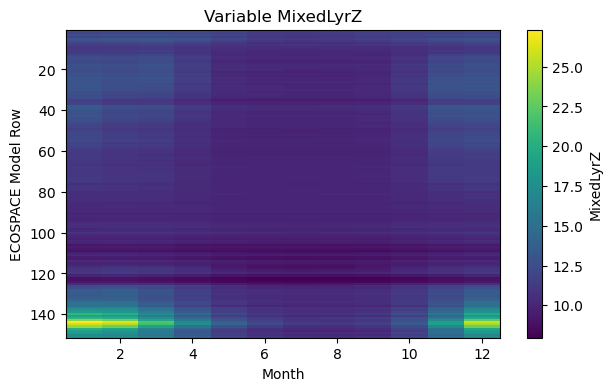

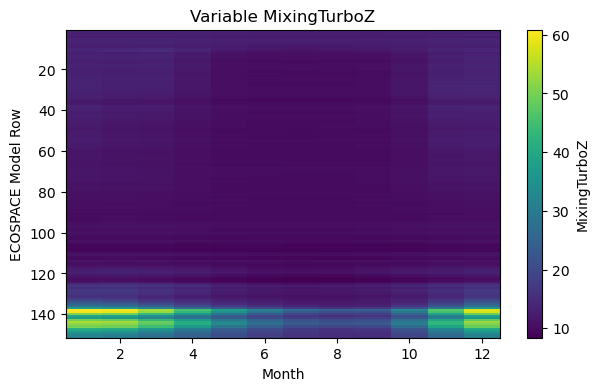

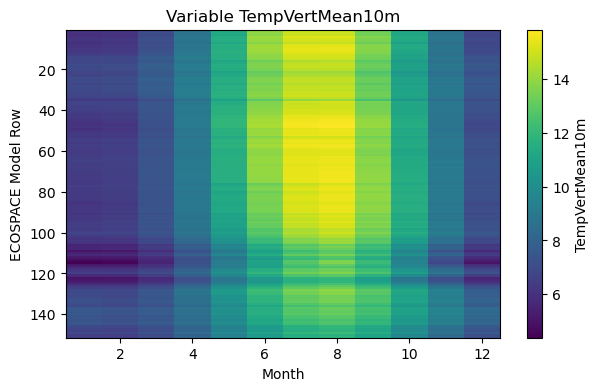

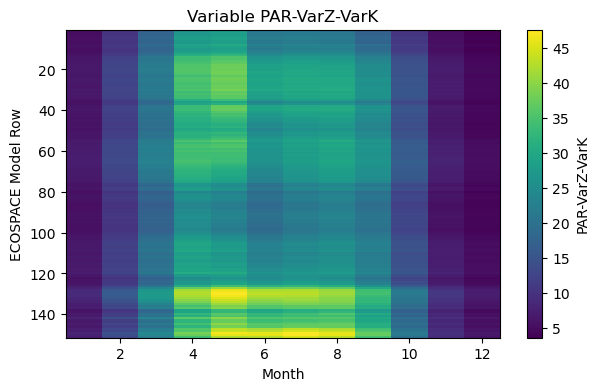

In [298]:
# climatologies

for v in v_f:
    v1 = ds2[v]
    q = v1.groupby('time.month').mean(dim='time').T
    
    fig, axs = plt.subplots(figsize = (7,4))
    xr.plot.pcolormesh(q, ax = axs)
    axs.set_title('Variable {v}'.format(v=v))
    #plt.colorbar(w, ax = axs)
    
    axs.invert_yaxis()
    axs.set_xlabel('Month')
    axs.set_ylabel('ECOSPACE Model Row')



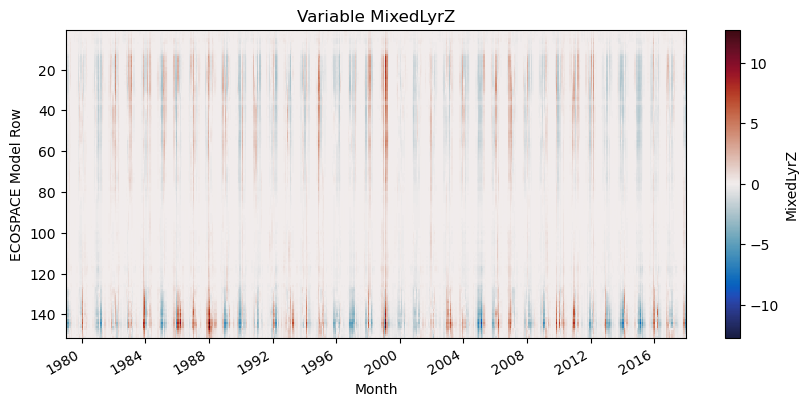

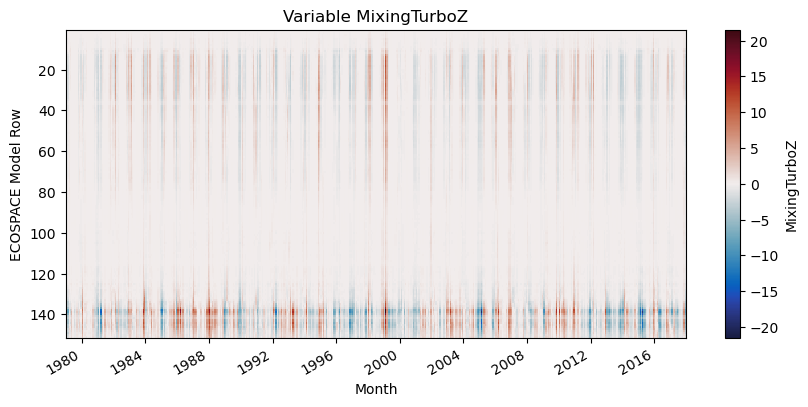

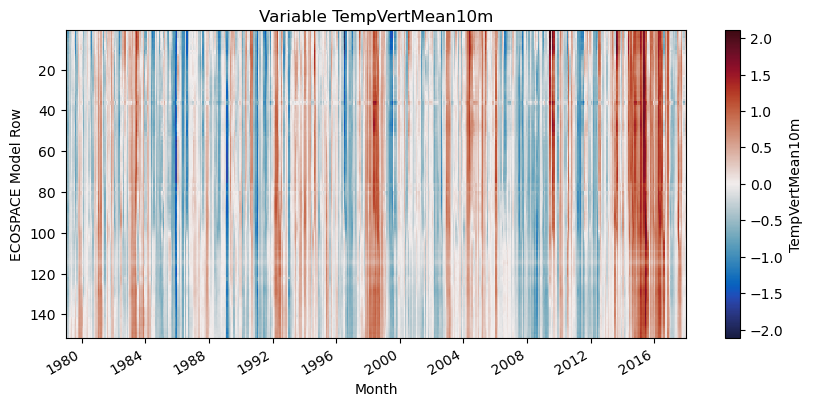

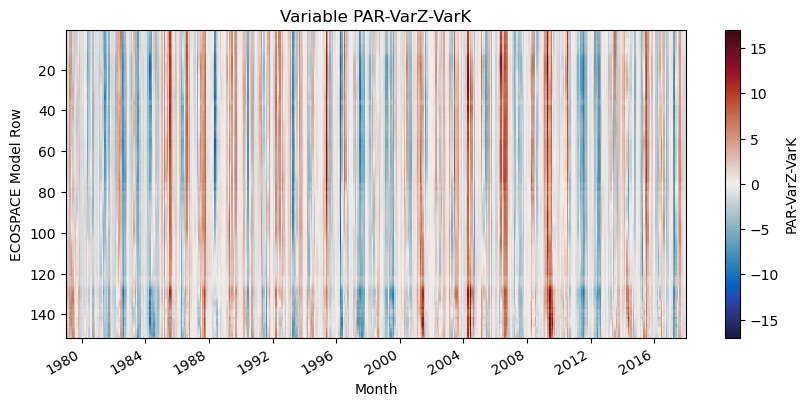

In [324]:
#var_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

for v in v_f:
    v1 = ds2[v]
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    #anom =  anom.isel(row = (anom.row > 0) & (anom.row < 30)) # change rows, explore n-s trends
    
    
    fig, axs = plt.subplots(figsize = (10,4))
    xr.plot.pcolormesh(anom, ax = axs,cmap = cm.cm.balance)
    axs.set_title('Variable {v}'.format(v=v))
    #plt.colorbar(w, ax = axs)
    
    axs.invert_yaxis()
    axs.set_xlabel('Month')
    axs.set_ylabel('ECOSPACE Model Row')



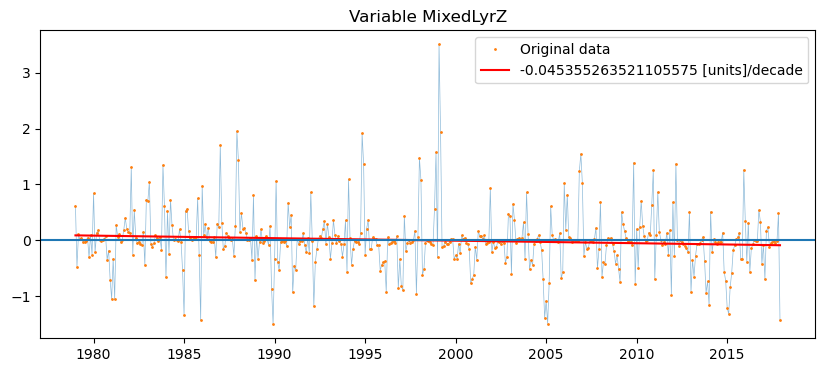

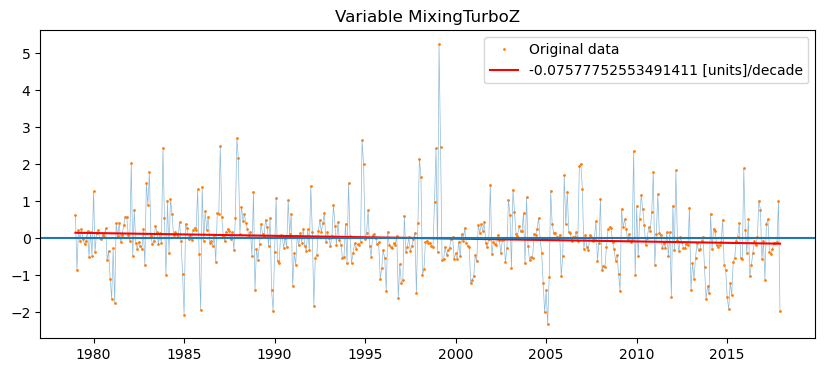

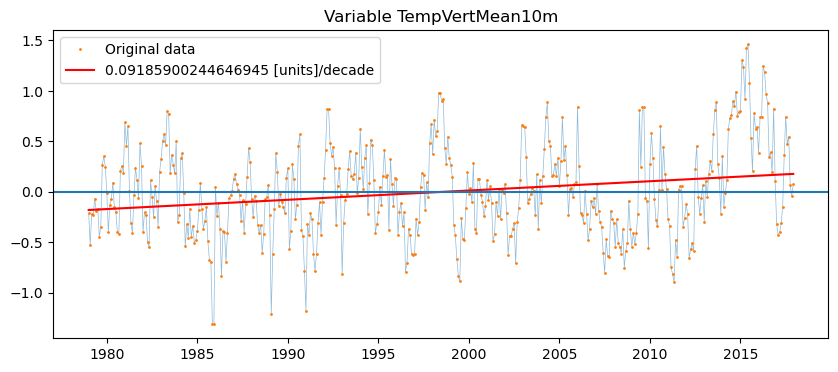

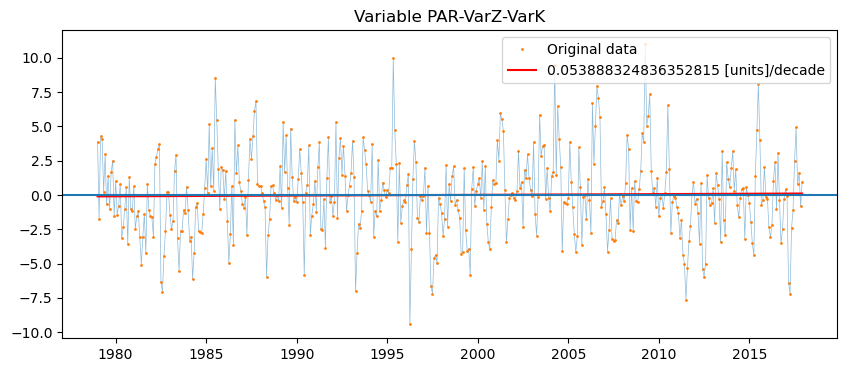

In [318]:
for v in v_f:
    v1 = ds2[v]
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    mean_anom =  anom.isel(row = (anom.row > 0) & (anom.row < 160)).mean(dim = 'row') # change rows, explore n-s trends
    
    tyr = np.arange(yr_strt,yr_end+1,(1/12))
    
    fig, axs = plt.subplots(figsize = (10,4))
    axs.plot(tyr, mean_anom.values,linewidth = 0.5, alpha = 0.5)
    
    # trend
    x = tyr[~np.isnan(mean_anom.values)]
    y = mean_anom.values[~np.isnan(mean_anom.values)]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    axs.plot(x, y, '.', label='Original data', markersize=2)
    axs.plot(x, m*x + c, 'r', label=f'{m*10} [units]/decade')
    axs.legend(loc = 'best')
    axs.axhline(y=0)
    axs.set_title('Variable {v}'.format(v=v))




In [ ]:
# there appears to be a n-s trend in temp. 
# redo above but for every cell in the map

In [ ]:
# experiments below

In [316]:
ds

<xarray.Dataset>
Dimensions:          (time: 468, row: 151, col: 93)
Coordinates:
  * time             (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2017-12-15
  * row              (row) int32 1 2 3 4 5 6 7 8 ... 145 146 147 148 149 150 151
  * col              (col) int32 1 2 3 4 5 6 7 8 9 ... 86 87 88 89 90 91 92 93
Data variables:
    MixedLyrZ        (time, row, col) float64 nan nan 36.5 50.4 ... nan nan nan
    MixingTurboZ     (time, row, col) float64 nan nan 43.9 56.4 ... nan nan nan
    TempVertMean10m  (time, row, col) float64 nan nan 7.4 7.4 ... nan nan nan
    PAR-VarZ-VarK    (time, row, col) float64 nan nan 5.2 4.4 ... nan nan nan
Attributes:
    description:  Example dataset of monthly ASC files

In [264]:
# to do - smooth and / or remove noise

# a quick de-noising fourier transform f(n)
# https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data



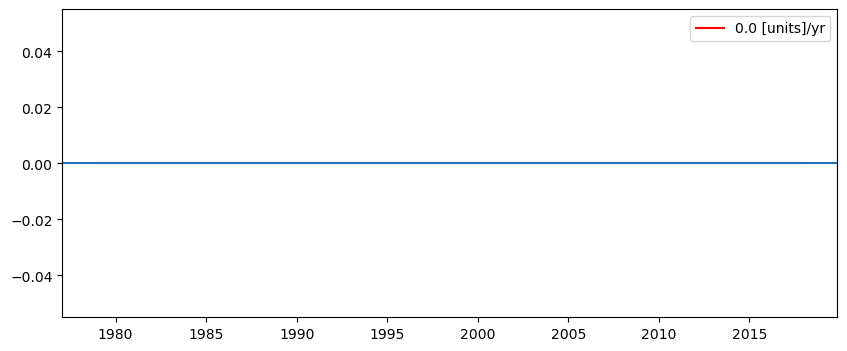

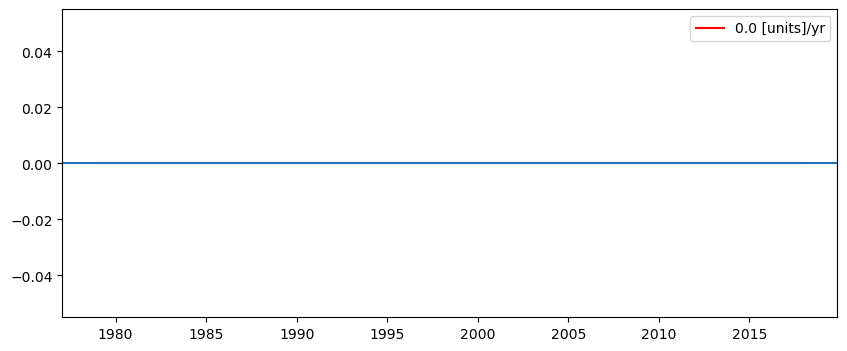

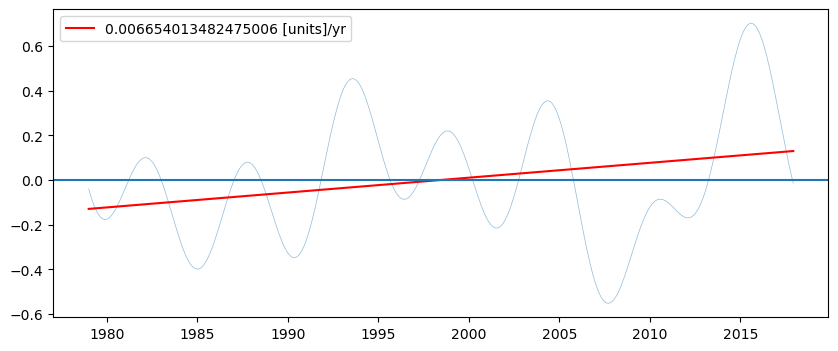

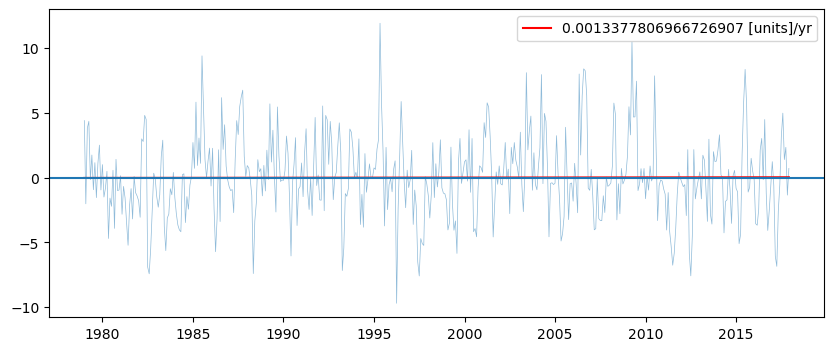

In [306]:
# not working don't trust


# to do: subregional look
for v in v_f:
    v1 = ds2[v]
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    mean_anom = anom.isel(row = (anom.row > 40) & (anom.row < 100)).mean(dim = 'row')
    tyr = np.arange(yr_strt,yr_end+1,(1/12))
    
    # ==== de-noiser ====
    n_components = 2
    mean_anom_smth = fft_denoiser(mean_anom, n_components, to_real=True)    
    
    fig, axs = plt.subplots(figsize = (10,4))
    
    # orig
    #axs.plot(tyr, mean_anom.values,linewidth = 0.5, alpha = 0.5)
    # smoothed
    axs.plot(tyr, mean_anom_smth,linewidth = 0.5, alpha = 0.5)
    
    # trend
    x = tyr[~np.isnan(mean_anom_smth)]
    y = mean_anom_smth[~np.isnan(mean_anom_smth)]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    
    #axs.plot(x, y, '.', label='Original data', markersize=2)
    axs.plot(x, m*x + c, 'r', label=f'{m} [units]/yr')
    axs.legend(loc = 'best')
    axs.axhline(y=0)